# Hierarchical Model
In this notebook, we implement the following hierarchical model in PyMC:

$$\begin{align*}
y &\sim \text{Normal}(\mu, \sigma)\\
\mu &= \alpha_{[ZIP]} + \beta_{[ZIP]} \text{area}\\
\alpha_{[ZIP]} &\sim \text{Normal}(\mu_{\alpha},\sigma_{\alpha}) \\
\beta_{[ZIP]} &\sim \text{Normal}(\mu_{\beta},\sigma_{\beta}) \\
\mu_{\alpha}, \mu_{\beta} &\sim \text{Normal}(0,100) \\
\sigma, \sigma_{\alpha}, \sigma_{\beta} &\sim \text{Exponential}(100)
\end{align*}$$

There are different ways to encode this model. The naive version is to use a center parametrization, however, for many problems this is not an optimal and a reparameterization, the non-centered version is a better alternative.
Another way to encode a hierarchical model, is to use instead a multivariate normal. I will present all three versions here.

In [1]:
import sys
sys.path.append('../src/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import theano

import arviz as az

from utils.data_utils import destandardize_area, destandardize_price, load_data
from utils.plot_utils import draw_model_plot, set_plot_defaults

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/corrie/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
set_plot_defaults(font="Europace Sans")
d, zip_lookup, num_zip_codes = load_data()
zip_codes = np.sort(d.zip.unique())

target = "price_s"

## Not very good Model
here, I actually accidently let $\sigma$ also vary by ZIP code. The idea in itself is actually not that stupid (makes sense that some heterogeneous ZIP codes vary maybe more than others in the price) but this implementation fails, as you can see in the trace plots. I leave it here just to give an example of some bad trace plots.

In [3]:
with pm.Model() as hier_model_naiv:
    mu_alpha = pm.Normal("mu_alpha", mu=0, sd=20)
    sigma_alpha = pm.Exponential("sigma_alpha", lam=1/2.5)
    
    mu_beta = pm.Normal("mu_beta", mu=0, sd=5)
    sigma_beta = pm.Exponential("sigma_beta", lam=1/2.5)
    
    alpha = pm.Normal("alpha", mu=mu_alpha, sd=sigma_alpha, shape=num_zip_codes)
    beta = pm.Normal("beta", mu=mu_beta, sd=sigma_beta, shape=num_zip_codes)
    # sigma also varies by zip code
    sigma = pm.Exponential("sigma", lam=1/2.5, shape=num_zip_codes)
    
    mu = alpha[d.zip_code.values] + beta[d.zip_code.values]*d.living_space_s
    y = pm.Normal("y", mu=mu, sd=sigma[d.zip_code.values], observed=d[target])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [10:49<00:00, 12.32draws/s] 
There were 321 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7095635801521762, but should be close to 0.8. Try to increase the number of tuning steps.
There were 324 divergences after tuning. Increase `target_accept` or reparameterize.
There were 389 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.638361360052169, but should be close to 0.8. Try to increase the number of tuning steps.
There were 421 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.598018163979549, but should be

In [4]:
bad_model = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=posterior_predictive,
                     coords={'zip_code': zip_codes},
                     dims={"alpha": ["zip_code"], "beta": ["zip_code"],
                          "sigma": ["zip_code"]})
bad_model

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

In [5]:
bad_model.to_netcdf("../models/bad_model.nc")

'../models/bad_model.nc'

In [6]:
az.summary(bad_model)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,3.601,0.056,3.494,3.703,0.003,0.002,293.0,291.0,307.0,201.0,1.01
mu_beta,2.691,0.089,2.534,2.858,0.006,0.004,235.0,235.0,239.0,49.0,1.02
alpha[0],4.989,0.161,4.661,5.244,0.009,0.006,326.0,318.0,345.0,1456.0,1.02
alpha[1],5.121,0.273,4.615,5.614,0.016,0.011,287.0,287.0,291.0,2053.0,1.02
alpha[2],5.040,0.258,4.596,5.541,0.018,0.013,212.0,212.0,226.0,435.0,1.02
...,...,...,...,...,...,...,...,...,...,...,...
sigma[214],1.808,1.719,0.015,4.724,0.056,0.040,944.0,944.0,682.0,1119.0,1.01
sigma[215],0.903,0.953,0.011,2.433,0.038,0.027,644.0,644.0,482.0,940.0,1.01
sigma[216],1.953,1.718,0.029,5.444,0.202,0.144,72.0,72.0,110.0,31.0,1.02
sigma[217],1.838,1.750,0.013,4.870,0.084,0.060,430.0,430.0,172.0,128.0,1.02


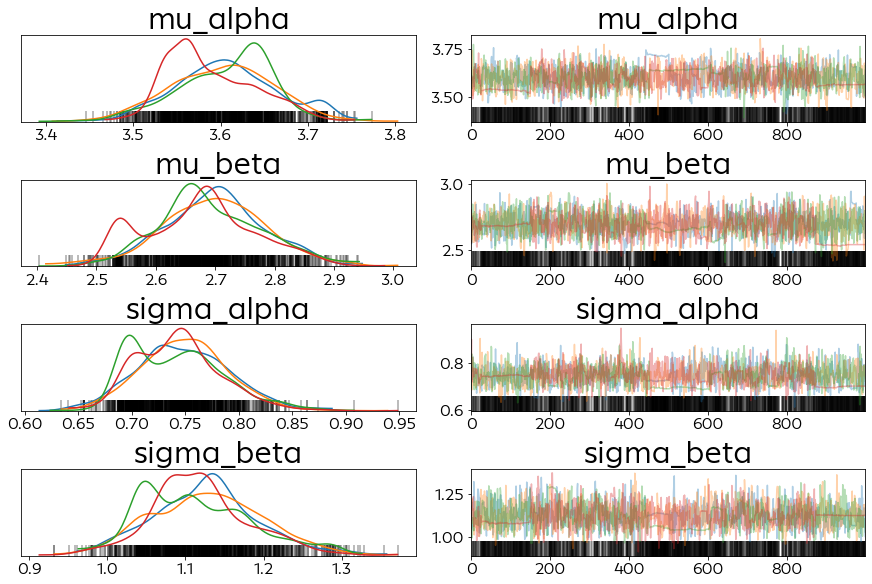

In [7]:
az.plot_trace(bad_model, var_names=["mu_alpha", "mu_beta", "sigma_alpha", "sigma_beta"])
plt.show()

## Centered Parameterization
The centered parameterization uses the same parameter description as in the model description above. For many problems, this is not the recommended parametrization, as discussed [here](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) by Thomas Wiecki, one of the PyMC core devs.

However, in some cases, the centered parametrization actually performs better than the non-centered parameterization, see e.g. this [discussion](https://discourse.mc-stan.org/t/centered-vs-non-centered-parameterizations/7344).

In [8]:
zips = theano.shared(d["zip_code"].values)
# idx variables cannnot used with pm.Data() so far, because of bug
# see here: https://discourse.pymc.io/t/integer-values-with-pm-data/3776
# and here: https://github.com/pymc-devs/pymc3/issues/3493

with pm.Model() as centered_hier_model:
    area = pm.Data("area", d["living_space_s"])
    #zips = pm.Data("zips", d["zip_code"].values)
    
    mu_alpha = pm.Normal("mu_alpha", mu=0, sd=20)
    sigma_alpha = pm.Exponential("sigma_alpha", lam=1/5)
    
    mu_beta = pm.Normal("mu_beta", mu=0, sd=5)
    sigma_beta = pm.Exponential("sigma_beta", lam=1/5)
    
    alpha = pm.Normal("alpha", mu=mu_alpha, sd=sigma_alpha, shape=num_zip_codes)
    beta = pm.Normal("beta", mu=mu_beta, sd=sigma_beta, shape=num_zip_codes)
    # without varying sigma
    sigma = pm.Exponential("sigma", lam=1/5)
    
    mu = alpha[zips] + beta[zips]*area
    y = pm.Normal("y", mu=mu, sd=sigma, observed=d[target])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
100%|██████████| 4000/4000 [00:09<00:00, 409.70it/s]


In [9]:
data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=posterior_predictive,
                     coords={'zip_code': zip_codes},
                     dims={"alpha": ["zip_code"], "beta": ["zip_code"]})
data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data
	> constant_data

In [ ]:
pm.save_trace(trace, directory="../models/centered_hier")

In [10]:
data.to_netcdf("../models/centered_hier.nc")

'../models/centered_hier.nc'

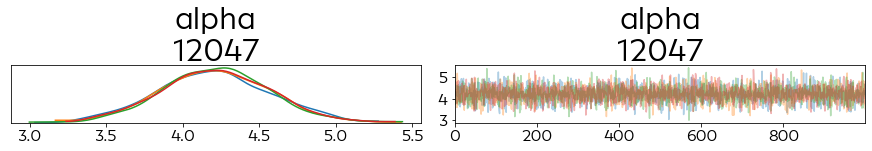

In [11]:
az.plot_trace(data.posterior.where(data.posterior.zip_code.isin(["12047"]), drop=True),
             var_names=["alpha"])
plt.show()

In [12]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,3.642,0.057,3.527,3.741,0.001,0.001,5524.0,5524.0,5535.0,3184.0,1.0
mu_beta,2.775,0.099,2.596,2.966,0.001,0.001,5782.0,5781.0,5766.0,3343.0,1.0
alpha[0],4.976,0.161,4.688,5.289,0.002,0.002,5618.0,5590.0,5626.0,3249.0,1.0
alpha[1],5.097,0.289,4.545,5.616,0.004,0.003,6018.0,6018.0,6017.0,3309.0,1.0
alpha[2],5.128,0.201,4.731,5.483,0.002,0.002,7223.0,7223.0,7272.0,3517.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta[217],2.668,1.280,0.290,4.958,0.014,0.012,7809.0,5449.0,7833.0,2742.0,1.0
beta[218],0.504,0.792,-0.999,1.999,0.009,0.011,7653.0,2519.0,7656.0,3127.0,1.0
sigma_alpha,0.741,0.044,0.664,0.830,0.001,0.000,4491.0,4491.0,4466.0,3015.0,1.0
sigma_beta,1.274,0.071,1.146,1.415,0.001,0.001,4779.0,4779.0,4726.0,3035.0,1.0


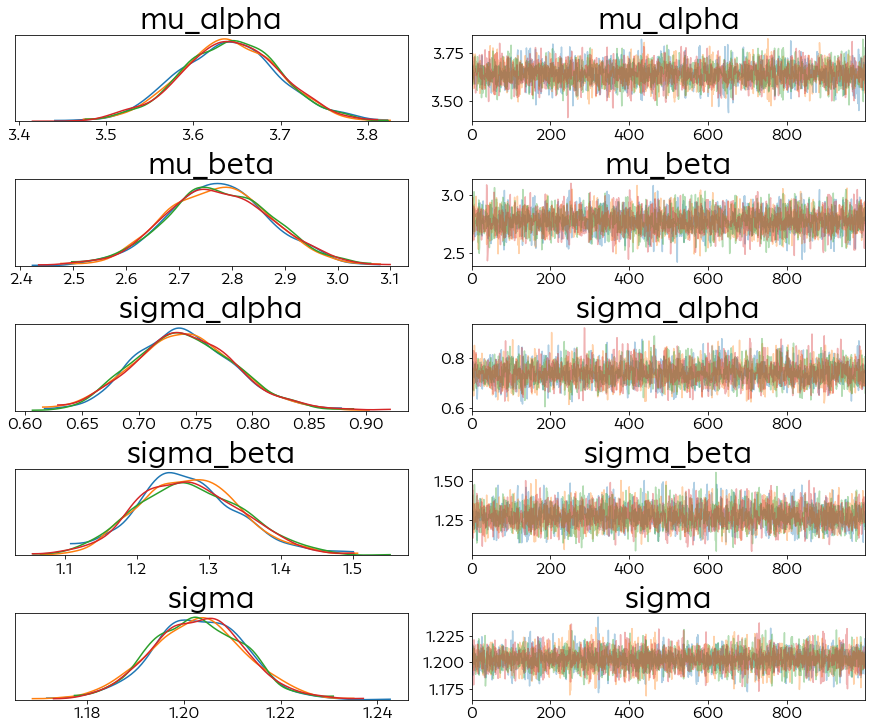

In [13]:
az.plot_trace(trace, var_names=["mu_alpha", "mu_beta", "sigma_alpha", "sigma_beta", "sigma"])
plt.show()

## Non-Centered Version
Often, this reparametrization works better. For a more detailed explanation, I refer again to the [blog post](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) by Thomas Wiecki.

In [14]:
with pm.Model() as non_centered_hier:
    
    beta_offset = pm.Normal("beta_offset", mu=0, sd=1, shape=num_zip_codes)
    
    mu_beta = pm.Normal("mu_beta", mu=0, sd=5)
    sigma_beta = pm.Exponential("sigma_beta", 1/5)
    beta = mu_beta + beta_offset*sigma_beta
    
    alpha_offset = pm.Normal("alpha_offset", mu=0, sd=1, shape=num_zip_codes)
    
    mu_alpha = pm.Normal("mu_alpha", mu=0, sd=20)
    sigma_alpha = pm.Exponential("sigma_alpha", 1/5)
    alpha = mu_alpha + alpha_offset*sigma_alpha
    
    mu = alpha[d.zip_code.values] + beta[d.zip_code.values]*d.living_space_s
    sigma = pm.Exponential("sigma", 1/5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=d[target])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, sigma_alpha, mu_alpha, alpha_offset, sigma_beta, mu_beta, beta_offset]
Sampling 4 chains: 100%|██████████| 8000/8000 [03:29<00:00, 38.28draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 4000/4000 [00:10<00:00, 364.94it/s]


In [15]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_offset[0],0.737,0.250,0.279,1.213,0.004,0.003,3385.0,2935.0,3383.0,2582.0,1.00
beta_offset[1],0.868,0.455,0.013,1.702,0.006,0.005,6135.0,4083.0,6237.0,2802.0,1.00
beta_offset[2],1.293,0.323,0.686,1.913,0.005,0.003,4578.0,4578.0,4561.0,3079.0,1.00
beta_offset[3],-0.205,0.938,-1.984,1.525,0.010,0.016,9016.0,1708.0,9001.0,3022.0,1.00
beta_offset[4],-0.079,0.949,-1.994,1.626,0.009,0.016,10836.0,1722.0,10794.0,2975.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
alpha_offset[218],-0.728,0.940,-2.407,1.085,0.011,0.011,7589.0,3522.0,7606.0,3218.0,1.00
mu_alpha,3.640,0.054,3.539,3.739,0.002,0.001,846.0,846.0,846.0,1481.0,1.00
sigma_beta,1.274,0.073,1.141,1.412,0.003,0.002,688.0,687.0,688.0,1545.0,1.01
sigma_alpha,0.741,0.043,0.660,0.819,0.001,0.001,1193.0,1193.0,1189.0,2030.0,1.00


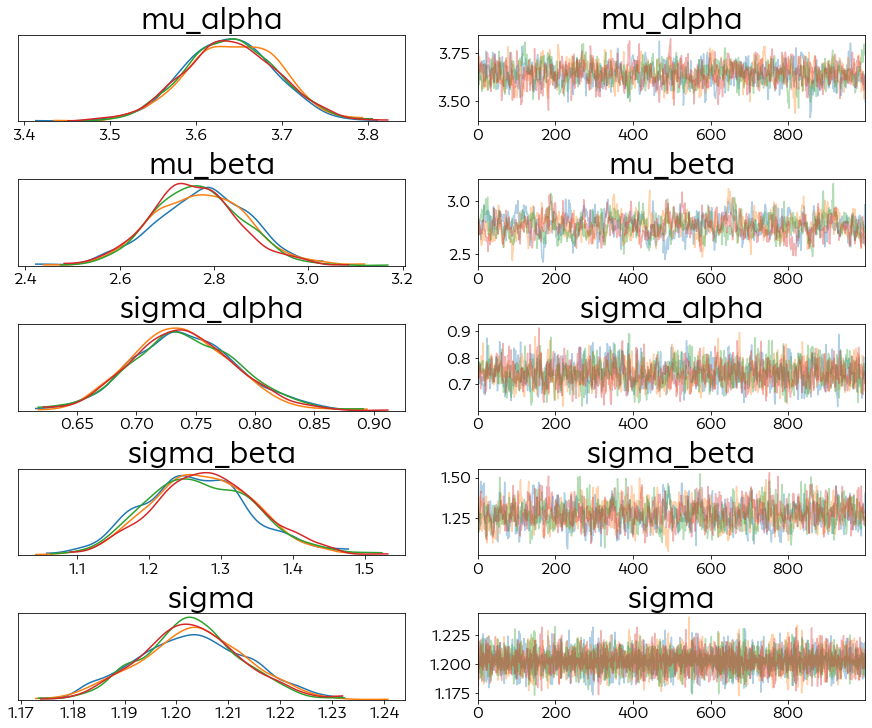

In [16]:
az.plot_trace(trace, var_names=["mu_alpha", "mu_beta", "sigma_alpha", "sigma_beta", "sigma"])
plt.show()

## Multivariate Model (includes correlation)
Another way of coding a hierarchical model is to use a multivariate normal distribution for the random effects:
$$\begin{align*}
y &\sim \text{Normal}(\mu, \sigma)\\
\mu &= \alpha_{[ZIP]} + \beta_{[ZIP]} \text{area}\\
\\
\begin{bmatrix}\alpha_{[ZIP]} \\ \beta_{[ZIP]} \end{bmatrix} &\sim \text{Normal}( \begin{bmatrix} \mu_{\alpha} \\ \mu_{\beta} \end{bmatrix}, \Sigma)\\
\mu_{\alpha}, \mu_{\beta} &\sim \text{Normal}(0,100) \\
\end{align*}$$

Setting the prior for the $\Sigma$ matrix is a bit more involved. The [Stan User Guide](https://mc-stan.org/docs/2_18/stan-users-guide/multivariate-hierarchical-priors-section.html) gives some explanation for how to pick the matrix prior.

In [17]:
with pm.Model() as correlation_hier_model: 
    # model specification is adapted from 
    # https://stackoverflow.com/questions/39364919/pymc3-how-to-model-correlated-intercept-and-slope-in-multilevel-linear-regressi
    # mu is mean vector for alpha and beta parameter
    mu = pm.Normal("mu", mu=0, sd=5, shape=(2,)) 
    # sigma is scale vector for alpha and beta parameter
    sigma = pm.Exponential("sigma", 1/5, shape=(2,))
    
    C_triu = pm.LKJCorr("C_triu", n=2, p=2)
    C = tt.fill_diagonal(C_triu[np.zeros((2,2), 'int')], 1.)
    # scale vector becomes diagonal of covariance matrix
    sigma_diag = tt.nlinalg.diag(sigma)
    cov = tt.nlinalg.matrix_dot(sigma_diag, C, sigma_diag)
    tau = tt.nlinalg.matrix_inverse(cov)
    
    # alpha and beta come from a multivariate normal
    # with mean vector mu
    # and covariance matrix tau 
    # tau includes scale for alpha and beta on the diagonals
    # and the correlation on  between alpha and beta off the diagonals
    ab = pm.MvNormal("ab", mu=mu, tau=tau, shape=(num_zip_codes, 2))
    
    sd_price = pm.Exponential("sd_price", lam=1/5)
    
    # compute estimate for price
    mean_price = ab[:,0][d.zip_code.values] + ab[:,1][d.zip_code.values]*d.living_space_s
    y = pm.Normal("y", mu=mean_price, sd=sd_price, observed=d[target])
    
    #prior = pm.sample_prior_predictive()
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/corrie/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/corrie/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/corrie/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarn

In [18]:
mvn_data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=posterior_predictive,
                     coords={'zip_code': zip_codes, 'param': ["alpha", "beta"],
                            "sigma_dim_0": ["alpha", "beta"]},
                     dims={"ab": ["zip_code", "param"],
                          "mu": ["param"]})
mvn_data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

In [19]:
mvn_data.to_netcdf("../models/mvn_hier.nc")

'../models/mvn_hier.nc'

In [ ]:
pm.save_trace(trace, directory="../models/mvn_hier")

In [20]:
az.summary(mvn_data)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],3.648,0.059,3.534,3.754,0.001,0.001,2995.0,2995.0,3018.0,2698.0,1.0
mu[1],2.762,0.102,2.578,2.955,0.002,0.001,2870.0,2869.0,2877.0,3188.0,1.0
"ab[0,0]",4.992,0.168,4.686,5.321,0.002,0.002,4780.0,4780.0,4766.0,2622.0,1.0
"ab[0,1]",3.817,0.310,3.240,4.404,0.004,0.003,4836.0,4836.0,4840.0,3241.0,1.0
"ab[1,0]",5.213,0.299,4.694,5.808,0.005,0.004,3573.0,3573.0,3573.0,3478.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"ab[218,1]",0.618,0.629,-0.532,1.818,0.008,0.007,6731.0,3561.0,6723.0,3093.0,1.0
sigma[0],0.768,0.044,0.685,0.852,0.001,0.001,2338.0,2328.0,2357.0,2385.0,1.0
sigma[1],1.293,0.073,1.159,1.430,0.001,0.001,2648.0,2646.0,2655.0,3208.0,1.0
C_triu[0],0.716,0.044,0.633,0.795,0.001,0.001,1920.0,1887.0,1859.0,2468.0,1.0
